- https://albertauyeung.github.io/2017/04/23/python-matrix-factorization.html

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import boxcox, inv_boxcox
from scipy import stats
from PIL import Image

from fastai.tabular.all import *
from fastai.collab import *

# Entregable Intelia

In [2]:
class RecSys():


    #############################################
    ############################################# CONSTRUCTOR
    #############################################

    def __init__(self, df_pairs, df_users=None, df_items=None, userName="customer_id", itemName="product_id", scoreName="peso"):
        
        self.trained   = 0
        self.user_embs = None
        self.item_embs = None

        ###################################### Save user-item pairs dataframe
        samples_user_id = df_pairs[userName].values;  self.userName = userName
        samples_item_id = df_pairs[itemName].values;  self.itemName = itemName
        samples_scores  = df_pairs[scoreName].values; self.scoreName = scoreName
        
        self.unique_user_ids, samples_user_iid = np.unique( samples_user_id, return_inverse=True)
        self.unique_item_ids, samples_item_iid = np.unique( samples_item_id, return_inverse=True)

        self.num_users = len(self.unique_user_ids)
        self.num_items = len(self.unique_item_ids)

        self.user_id_2_iid   = lambda user_id: self.unique_user_ids.tolist().index(user_id)
        self.item_id_2_iid   = lambda item_id: self.unique_item_ids.tolist().index(item_id)
        #self.user_iids_2_ids = lambda user_iids: self.unique_user_ids[ user_iids ]
        #self.item_iids_2_ids = lambda item_iids: self.unique_item_ids[ item_iids ]

        # Sparse matrix: List of tuples [(user,item,score), (user,item,score), ...]
        #self.samples = list(zip(samples_user_iid, samples_item_iid, samples_scores))
        
        # Sparse matrix: Matrix of samples [[user,item,score], [user,item,score], ...]
        #self.samples = np.column_stack((samples_user_iid, samples_item_iid, samples_scores))
        
        # self.samples is a Numpy record array: https://numpy.org/doc/stable/user/basics.rec.html#record-arrays
        self.samples = np.rec.fromarrays((samples_user_iid, samples_item_iid, samples_scores),
                                         names=('user', 'item', "score"))
        
        self.b = self.samples.score.mean()
        
        ########################### Save user and item extra information
        self.df_users = df_users
        self.df_items = df_items
        
        # if df_users
        # Comprobar que los df_pairs.user_id esten en df_users.id

        # if df_items
        # Comprobar que los df_pairs.item_id esten en df_items.id


    #################################### FUNCIONES ####################################
    #################################### PARA USAR ####################################
    #################################### EL MODELO ####################################


    ### Sugerir productos a usario concreto
    def sugerirProds_a_usuario(self, user_id, limit=0.3):

        return self.emb_simSearch(
                        query_emb     = self.get_user_emb(user_id),
                        searchOn_embs = self.item_embs,
                        searchOn_ids  = self.unique_item_ids,
                        limit         = limit)

    ### Audiencia de usuarios de producto concreto
    def adienciaUsuaros_de_prod(self, item_id, limit=0.3):

        return self.emb_simSearch(
                        query_emb     = self.get_item_emb(item_id),
                        searchOn_embs = self.user_embs,
                        searchOn_ids  = self.unique_user_ids,
                        limit         = limit)


    ### Listar productos que normalmente se compran juntos
    def productos_parecidos(self, item_id, limit=0.3):

        return self.emb_simSearch(
                        query_emb     = get_item_emb(item_id),
                        searchOn_embs = self.item_embs,
                        searchOn_ids  = self.unique_item_ids,
                        limit         = limit)


    #################################################

    def get_user_emb(self, user_id):
        
        if not user_id in self.unique_user_ids:
            print(f"ERROR: El usuario {user_id} no ha comprado o visto por ningun producto todavía.")
            print("Los ids de usuario disponibles son:\n", self.unique_user_ids)
            return None
        else:
            user_iid = self.user_id_2_iid( user_id ) # 1) Convert real user id to internal user id
            user_emb = self.user_embs[ user_iid ]    # 2) Get user embedding
            return user_emb


    def get_item_emb(self, item_id):

        if not item_id in self.unique_item_ids:
            print("ERROR:")
            print(f"El producto {item_id} no ha sido comprado o visto por ningun cliente todavia.")
            print("Puedes ver los ids de producto disponibles con el atributo .unique_item_ids")
            print()
            return None
        else:
            item_iid = self.item_id_2_iid( item_id ) # 1) Convert real item id to internal item id
            item_emb = self.item_embs[ item_iid ]    # 2) Get item id embedding


    def emb_simSearch(self, query_emb, searchOn_embs, searchOn_ids, limit=0.3):


        if self.trained == 0:
            print("ERROR:")
            print("El modelo todavía no se ha entrenado. Por favor llama al metodo train()")
            print()
            return
        elif self.trained > 0 and self.trained < 1:
            print("WARNING:")
            print(f"El modelo ha sido entrenado sólo con el {self.trained * 100}% de los datos.")
            print("Se recomienda reentrenar al modelo con el 100% de los datos")
            print("con parametros que eviten en sobreajuste (overfitting).")
            print("Por favor, reentrena llamando al metodo train(train_perc=1)")
            print()

        if query_emb     is None: return
        if searchOn_embs is None: return
            
        assert limit > 0 and limit < 1
        assert len(searchOn_embs)==len(searchOn_ids)



        # 1. Similarity scores (pairwise cosine similarity)
        similarities = searchOn_embs @ query_emb

        # 2. Get good ones by threashold
        bool_matches = similarities > limit

        # 3. Filter by matched
        selected_ids          = searchOn_ids[bool_matches]
        selected_similarities = similarities[bool_matches]

        # 4: sort by similarity value
        sorted_order = selected_similarities.argsort()[::-1] # Descending order positions
        return selected_ids[sorted_order]



    #################################### FUNCIONES DE  ####################################
    #################################### ENTRENAMIENTO #################################### 
    #################################### DE EMBEDDINGS ####################################

    def train(self, embSize, lr, wd, epochs, train_perc=1, l2_norm=True):
        """
        Perform matrix factorization to predict empty entries in a matrix.

        Arguments
        - embSize (int)    : number of latent dimensions
        - lr (float)       : learning rate
        - wd (float)       : regularization parameter
        """
        
        # Initialize user and item embeddings
        self.user_embs = np.random.normal(scale=1./embSize, size=(self.num_users, embSize))
        self.item_embs = np.random.normal(scale=1./embSize, size=(self.num_items, embSize))

        # Initialize user and item biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)

        # Separate training and validation samples
        split_idx = int(len(self.samples) * train_perc)
        np.random.shuffle(self.samples)
        self.train_samples = self.samples[:split_idx]
        self.valid_samples = self.samples[split_idx:]

        # Perform stochastic gradient descent for number of epochs
        training_process = {"epoch": [], "train_mae": [], "valid_mae": [], "train_mse": [], "valid_mse": []}
        for i in range(epochs):
            self.sgd_epoch(lr, wd)
            train_mae, train_mse, valid_mae, valid_mse = self.errors()
            training_process["epoch"].append(i+1)
            training_process["train_mae"].append(train_mae)
            training_process["valid_mae"].append(valid_mae)
            training_process["train_mse"].append(train_mse)
            training_process["valid_mse"].append(valid_mse)
            print("Epoch: %d ; trMAE = %.4f trMSE = %.4f valMAE = %.4f valMSE = %.4f" % (i+1, train_mae, train_mse, valid_mae, valid_mse))

        self.plot_training(training_process)

        # Normalize embeddings
        if l2_norm:
            self.user_embs = self.l2_norm(self.user_embs)
            self.item_embs = self.l2_norm(self.item_embs)

        self.trained = train_perc



    def sgd_epoch(self, lr, wd):
        """
        Perform stochastic graident descent epoch
        """
        np.random.shuffle(self.train_samples) # This also shuffles self.samples !!!
        for user, item, groudTruth in self.train_samples:

            # Computer prediction and error
            prediction = self.get_score(user, item)
            err = (groudTruth - prediction)

            # Update biases
            self.b_u[user] += lr * (err - wd * self.b_u[user])
            self.b_i[item] += lr * (err - wd * self.b_i[item])

            # Update user and item embeddings
            self.user_embs[user, :] += lr * (err * self.item_embs[item, :] - wd * self.user_embs[user,:])
            self.item_embs[item, :] += lr * (err * self.user_embs[user, :] - wd * self.item_embs[item,:])


    def errors(self):
        """
        A function to compute the errors
        """
        predicted = self.full_matrix()
        
        train_mae = 0
        train_mse = 0
        for x, y, real in self.train_samples:
            diference = real - predicted[x, y]
            train_mae += abs(diference)
            train_mse += pow(diference, 2)
        train_mae /= len(self.train_samples)
        train_mse /= len(self.train_samples)

        valid_mae = 0
        valid_mse = 0
        for x, y, real in self.valid_samples:
            diference = real - predicted[x, y]
            valid_mae += abs(diference)
            valid_mse += pow(diference, 2)  
        valid_mae /= len(self.valid_samples)
        valid_mse /= len(self.valid_samples)
        
        return train_mae, train_mse, valid_mae, valid_mse
        

    def plot_training(self, training_process):
        self.plot_metric(training_process, metric="mae", title="Mean Absolute Error")
        self.plot_metric(training_process, metric="mse", title="Mean Square Error")

    def plot_metric(self, training_process, metric, title):
        plt.figure(figsize=((16,4)))
        plt.tick_params(labelright=True)
        plt.plot(training_process["epoch"], training_process["train_"+metric])
        plt.plot(training_process["epoch"], training_process["valid_"+metric], linewidth=3)
        plt.xticks(training_process["epoch"], training_process["epoch"])
        plt.xlabel("Epoch")
        #plt.ylabel(metric)
        plt.title(title)
        plt.grid(axis="y")
        plt.show()

    def get_score(self, u, i):
        """
        Get the predicted score of user u and item i
        """
        return self.b + self.b_u[u] + self.b_i[i] + self.user_embs[u, :].dot(self.item_embs[i, :].T)


    def full_matrix(self):
        """
        Compute the full matrix:
        Matrix product of embedding, plus broadcasting biases.
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i + (self.user_embs @ self.item_embs.T)
    

    def draw_matrix(self, margin=True):
        
        print("Number of users:", self.num_users)
        print("Number of items:", self.num_items)
        print("Number of interactions:", len(self.samples))
                          
        if margin and (self.df_users is not None) and (self.df_items is not None):
            matrix = np.full( shape=(len(self.df_users), len(self.df_items)), fill_value=127, dtype=np.uint8 )
            matrix[:self.num_users, :self.num_items] = 0
        else:
            matrix = np.full( shape=(self.num_users, self.num_items), fill_value=0, dtype=np.uint8 )
            
        for user_idx, item_idx, score in self.samples:
            matrix[user_idx, item_idx] = 255
    
        display(Image.fromarray(matrix))
        
        plt.figure(figsize=((4,2)))
        plt.title(self.scoreName)
        plt.hist(self.samples.score, bins=20)
        plt.show()
        
    def l2_norm(self, emb_matrix):
        norms = np.sqrt( np.sum( emb_matrix**2, axis=1) )
        norms = np.clip( norms, a_min=1e-10, a_max=np.inf ) # Avoid dividing by zero
        #norms = np.linalg.norm(x, axis=1) # Otra forma de calcular los norms
        return emb_matrix / norms[:,np.newaxis]

# <center> Datos Fastai (MovieLens 100K)

In [3]:
path = untar_data(URLs.ML_100k)
df_fastai = pd.read_csv(path/'u.data', delimiter='\t', header=None, usecols=(0,1,2), names=['user','movie','rating'])
df_fastai.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
movielens = RecSys(df_fastai, userName="user", itemName="movie", scoreName="rating")

Number of users: 943
Number of items: 1682
Number of interactions: 100000


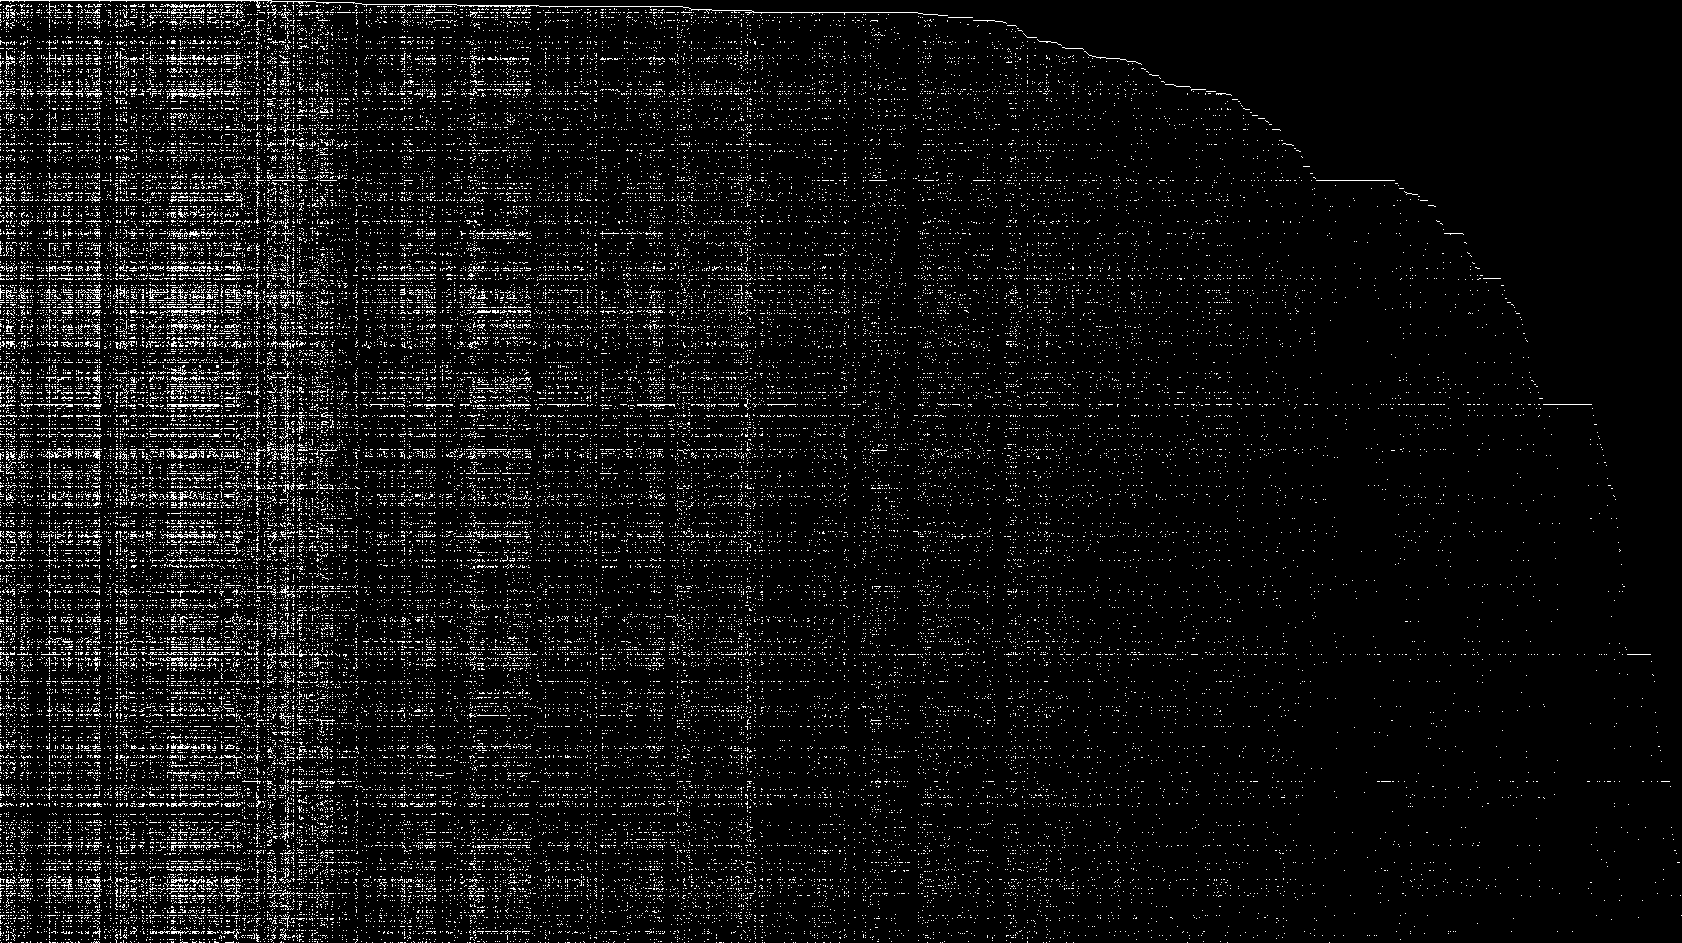

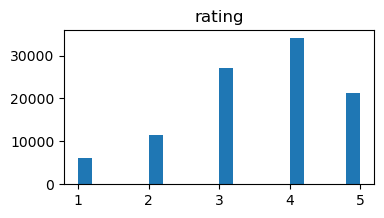

In [5]:
movielens.draw_matrix()

## Train with fast.ai

In [6]:
dls = CollabDataLoaders.from_df(ratings=df_fastai,
                                valid_pct=0.2,
                                user_name="user",
                                item_name="movie",
                                rating_name="rating",
                                seed=None,
                                bs=64)

learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5), metrics=[mae])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,mae,time
0,0.943618,0.942439,0.773985,00:04
1,0.878812,0.871426,0.742969,00:04
2,0.716628,0.826962,0.721399,00:04
3,0.585391,0.815611,0.715330,00:04
4,0.468235,0.815355,0.715061,00:04


## Train with my module

Epoch: 1 ; trMAE = 0.7753 trMSE = 0.9368 valMAE = 0.7836 valMSE = 0.9622
Epoch: 2 ; trMAE = 0.7535 trMSE = 0.8934 valMAE = 0.7649 valMSE = 0.9264
Epoch: 3 ; trMAE = 0.7436 trMSE = 0.8741 valMAE = 0.7568 valMSE = 0.9108
Epoch: 4 ; trMAE = 0.7385 trMSE = 0.8633 valMAE = 0.7523 valMSE = 0.9019
Epoch: 5 ; trMAE = 0.7350 trMSE = 0.8567 valMAE = 0.7505 valMSE = 0.8985
Epoch: 6 ; trMAE = 0.7332 trMSE = 0.8525 valMAE = 0.7494 valMSE = 0.8958
Epoch: 7 ; trMAE = 0.7315 trMSE = 0.8490 valMAE = 0.7480 valMSE = 0.8926
Epoch: 8 ; trMAE = 0.7310 trMSE = 0.8470 valMAE = 0.7481 valMSE = 0.8927
Epoch: 9 ; trMAE = 0.7296 trMSE = 0.8444 valMAE = 0.7470 valMSE = 0.8905
Epoch: 10 ; trMAE = 0.7285 trMSE = 0.8428 valMAE = 0.7463 valMSE = 0.8895
Epoch: 11 ; trMAE = 0.7273 trMSE = 0.8408 valMAE = 0.7455 valMSE = 0.8882
Epoch: 12 ; trMAE = 0.7270 trMSE = 0.8391 valMAE = 0.7454 valMSE = 0.8871
Epoch: 13 ; trMAE = 0.7263 trMSE = 0.8379 valMAE = 0.7450 valMSE = 0.8871
Epoch: 14 ; trMAE = 0.7252 trMSE = 0.8360 valMA

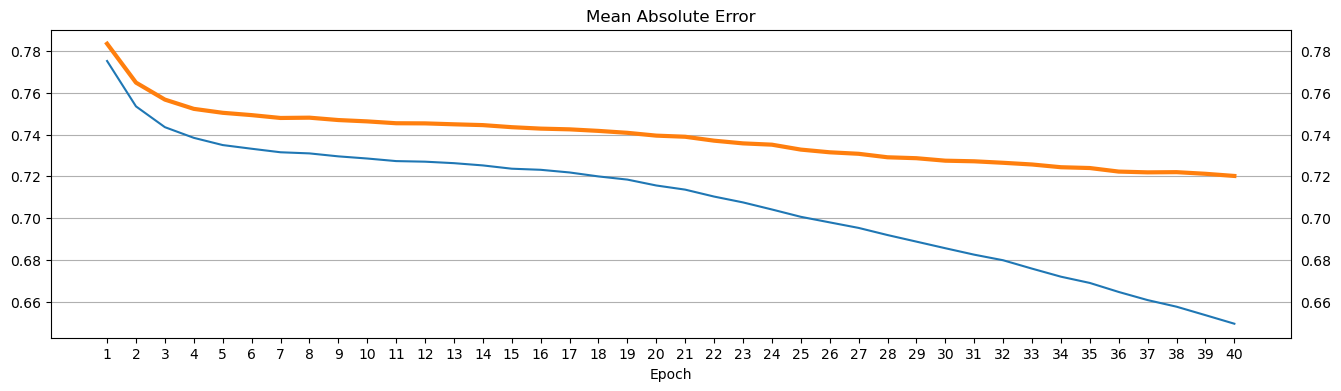

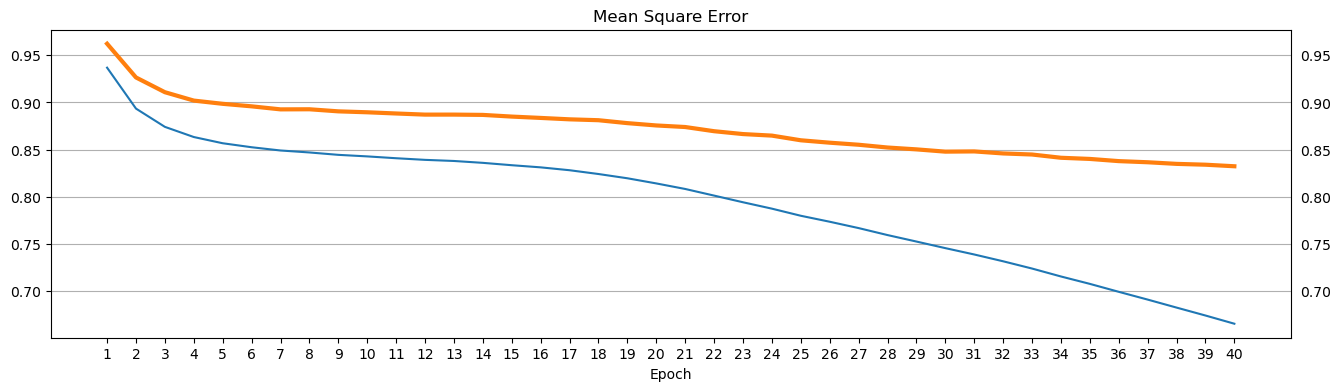

In [44]:
movielens.train(embSize=50, lr=0.01, wd=0.1, epochs=40, train_perc=0.8)

# Datios Intelia

Se pueden realizar pruebas con cualquier compañía pero me gustaría empezar por la 23 y 15.

In [3]:
!ls data

customers.csv  products.csv  relation.csv


In [4]:
dataPath = "data/"

df_intelia_users = pd.read_csv(dataPath + "customers.csv")
df_intelia_items = pd.read_csv(dataPath + "products.csv")
df_intelia_pairs = pd.read_csv(dataPath + "relation.csv")

/tmp/ipykernel_557/1378237331.py:3: DtypeWarning: Columns (7,9,10,11,12,13,17,18,21,26,27,28,30,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_intelia_users = pd.read_csv(dataPath + "customers.csv")
/tmp/ipykernel_557/1378237331.py:4: DtypeWarning: Columns (20,32,34,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df_intelia_items = pd.read_csv(dataPath + "products.csv")


In [5]:
df_intelia_pairs["peso_logNat"] = np.log(df_intelia_pairs.peso + 1)
df_intelia_pairs["peso_logB2"]  = np.log2(df_intelia_pairs.peso + 1)
df_intelia_pairs["peso_logB10"] = np.log10(df_intelia_pairs.peso + 1)

## No hay duplicados

In [6]:
df_intelia_pairs [ df_intelia_pairs[["company_id", "product_id", "customer_id"]].duplicated() ]

,company_id,product_id,customer_id,peso,ultimo,peso_logNat,peso_logB2,peso_logB10


In [7]:
df_intelia_pairs [ df_intelia_pairs[["product_id", "customer_id"]].duplicated() ]

,company_id,product_id,customer_id,peso,ultimo,peso_logNat,peso_logB2,peso_logB10


# Compañias

In [8]:
company_ids = df_intelia_pairs.company_id.unique() #.tolist()
company_ids

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 18, 19, 21,
       23, 24, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 44])

In [9]:
def get_dfs_company(comp_id):
    return df_intelia_pairs[ df_intelia_pairs.company_id == comp_id], \
           df_intelia_users[ df_intelia_users.company_id == comp_id], \
           df_intelia_items[ df_intelia_items.company_id == comp_id]

# Compañia 1

Number of users: 314
Number of items: 296
Number of interactions: 14902


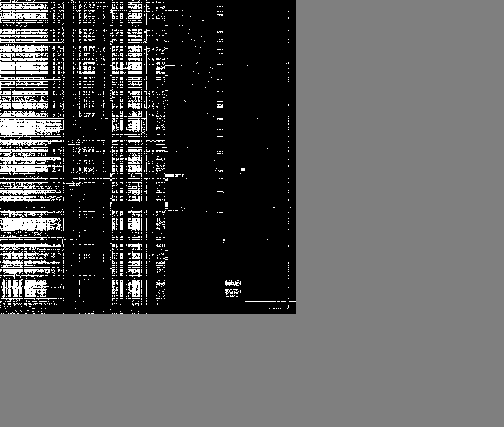

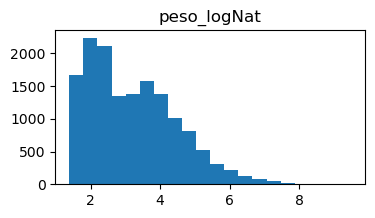

In [10]:
rs1 = RecSys(*get_dfs_company(1), userName="customer_id", itemName="product_id", scoreName="peso_logNat")
rs1.draw_matrix()

In [11]:
rs1.user_embs

In [12]:
rs1.adienciaUsuaros_de_prod(item_id=200)

ERROR:
El producto 200 no ha sido comprado o visto por ningun cliente todavia.
Puedes ver los ids de producto disponibles con el atributo .unique_item_ids

ERROR:
El modelo todavía no se ha entrenado. Por favor llama al metodo train()



Epoch: 1 ; trMAE = 0.8256 trMSE = 1.0205 valMAE = 0.8254 valMSE = 1.0229
Epoch: 2 ; trMAE = 0.7239 trMSE = 0.8153 valMAE = 0.7272 valMSE = 0.8331
Epoch: 3 ; trMAE = 0.6704 trMSE = 0.7192 valMAE = 0.6746 valMSE = 0.7445
Epoch: 4 ; trMAE = 0.6395 trMSE = 0.6638 valMAE = 0.6431 valMSE = 0.6945
Epoch: 5 ; trMAE = 0.6200 trMSE = 0.6283 valMAE = 0.6241 valMSE = 0.6636
Epoch: 6 ; trMAE = 0.6055 trMSE = 0.6022 valMAE = 0.6105 valMSE = 0.6417
Epoch: 7 ; trMAE = 0.5949 trMSE = 0.5821 valMAE = 0.6013 valMSE = 0.6249
Epoch: 8 ; trMAE = 0.5850 trMSE = 0.5649 valMAE = 0.5938 valMSE = 0.6122
Epoch: 9 ; trMAE = 0.5771 trMSE = 0.5497 valMAE = 0.5871 valMSE = 0.5997
Epoch: 10 ; trMAE = 0.5689 trMSE = 0.5344 valMAE = 0.5806 valMSE = 0.5882


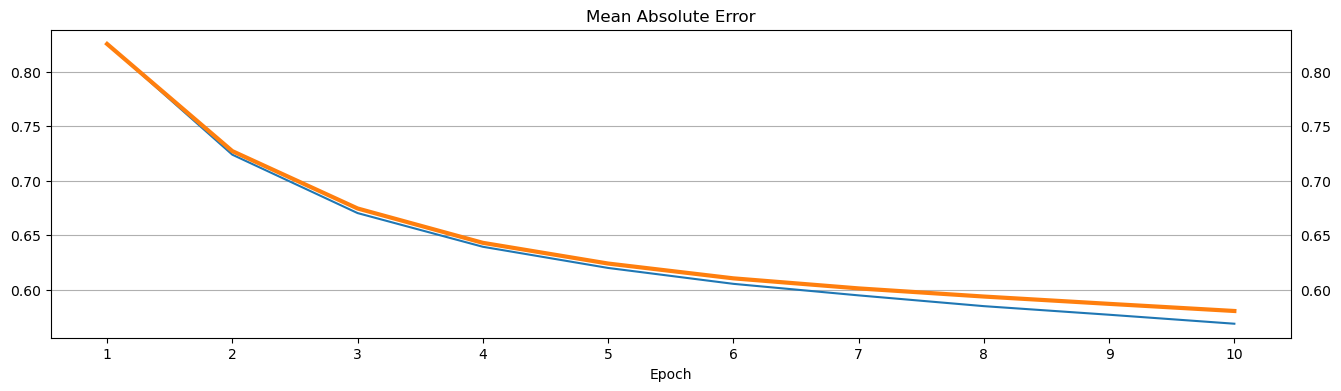

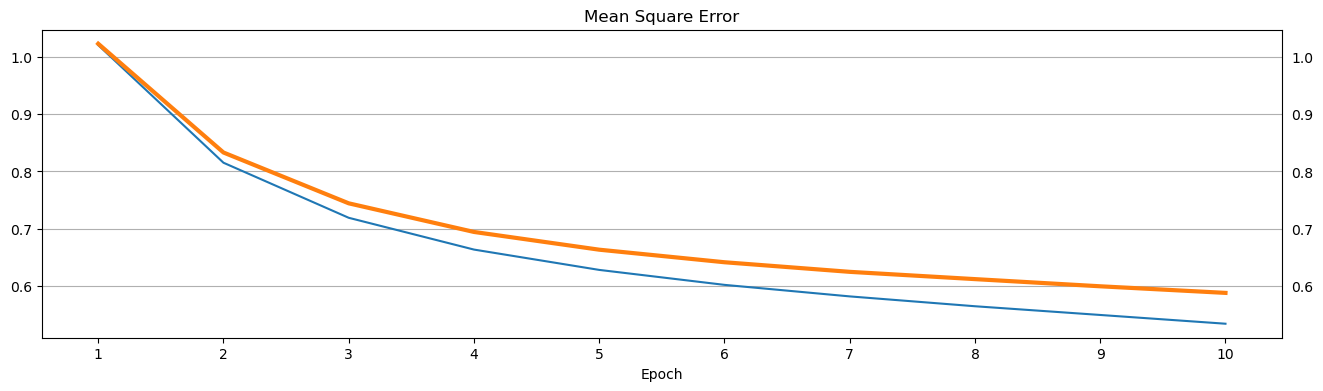

In [13]:
rs1.train(embSize=50, lr=0.01, wd=0.1, epochs=10, train_perc=0.8)

In [14]:
rs1.adienciaUsuaros_de_prod(item_id=200)

ERROR:
El producto 200 no ha sido comprado o visto por ningun cliente todavia.
Puedes ver los ids de producto disponibles con el atributo .unique_item_ids

El modelo ha sido entrenado sólo con el 80.0% de los datos.
Se recomienda reentrenar al modelo con el 100% de los datos
con parametros que eviten en sobreajuste (overfitting).
Por favor, reentrena llamando al metodo train(train_perc=1)



In [19]:
rs1.adienciaUsuaros_de_prod(item_id=132)

El modelo ha sido entrenado sólo con el 80.0% de los datos.
Se recomienda reentrenar al modelo con el 100% de los datos
con parametros que eviten en sobreajuste (overfitting).
Por favor, reentrena llamando al metodo train(train_perc=1)



## Train with fast.ai

In [30]:
dls = CollabDataLoaders.from_df(ratings=get_dfs_company(1)[0],
                                valid_pct=0.2,
                                user_name="customer_id",
                                item_name="product_id",
                                rating_name="peso_logNat",
                                seed=None,
                                bs=64)
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5), metrics=[mae])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,mae,time
0,1.276232,0.757377,0.670435,00:00
1,0.540055,0.492611,0.525336,00:00
2,0.449521,0.435794,0.491706,00:00
3,0.384841,0.420299,0.484427,00:00
4,0.332034,0.418090,0.482905,00:00


## Train with my module

Epoch: 1 ; trMAE = 0.6199 trMSE = 0.6323 valMAE = 0.6476 valMSE = 0.7106
Epoch: 2 ; trMAE = 0.5687 trMSE = 0.5419 valMAE = 0.6013 valMSE = 0.6367
Epoch: 3 ; trMAE = 0.5270 trMSE = 0.4656 valMAE = 0.5669 valMSE = 0.5678
Epoch: 4 ; trMAE = 0.4940 trMSE = 0.4107 valMAE = 0.5391 valMSE = 0.5156
Epoch: 5 ; trMAE = 0.4788 trMSE = 0.3836 valMAE = 0.5295 valMSE = 0.4949
Epoch: 6 ; trMAE = 0.4687 trMSE = 0.3673 valMAE = 0.5249 valMSE = 0.4857
Epoch: 7 ; trMAE = 0.4644 trMSE = 0.3539 valMAE = 0.5183 valMSE = 0.4697
Epoch: 8 ; trMAE = 0.4480 trMSE = 0.3363 valMAE = 0.5082 valMSE = 0.4547
Epoch: 9 ; trMAE = 0.4364 trMSE = 0.3178 valMAE = 0.5013 valMSE = 0.4484
Epoch: 10 ; trMAE = 0.4332 trMSE = 0.3076 valMAE = 0.5020 valMSE = 0.4421
Epoch: 11 ; trMAE = 0.4329 trMSE = 0.3032 valMAE = 0.5013 valMSE = 0.4405
Epoch: 12 ; trMAE = 0.4210 trMSE = 0.2897 valMAE = 0.4956 valMSE = 0.4360
Epoch: 13 ; trMAE = 0.4181 trMSE = 0.2858 valMAE = 0.4920 valMSE = 0.4306
Epoch: 14 ; trMAE = 0.4132 trMSE = 0.2770 valMA

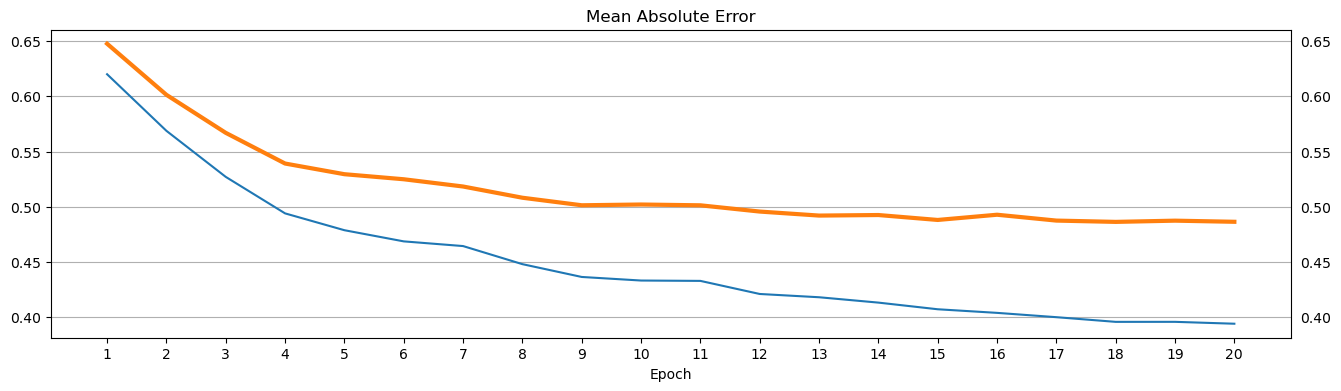

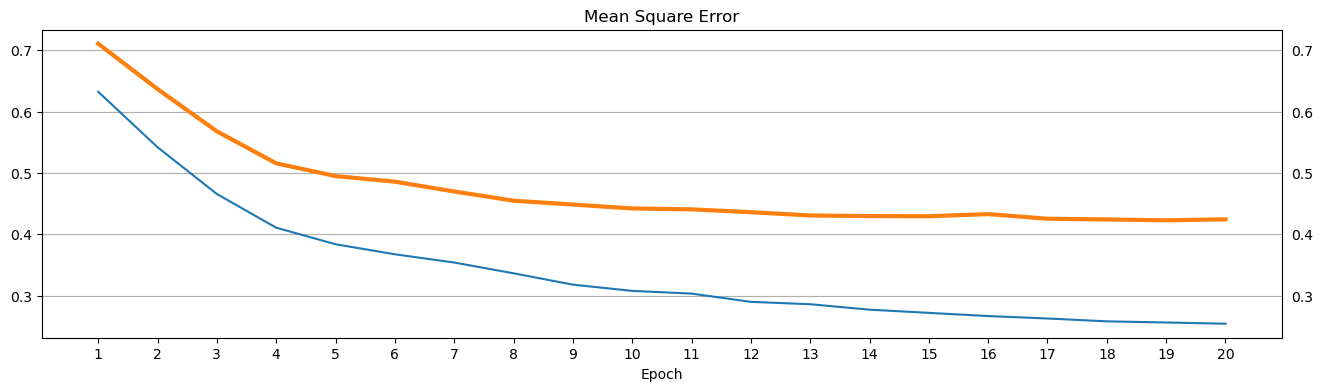

In [17]:
rs1.train(embSize=50, lr=5e-2, wd=0.1, epochs=20, train_perc=0.8)

# Otras compañias



COMPAÑÍA: 1
Number of users: 314
Number of items: 296
Number of interactions: 14902


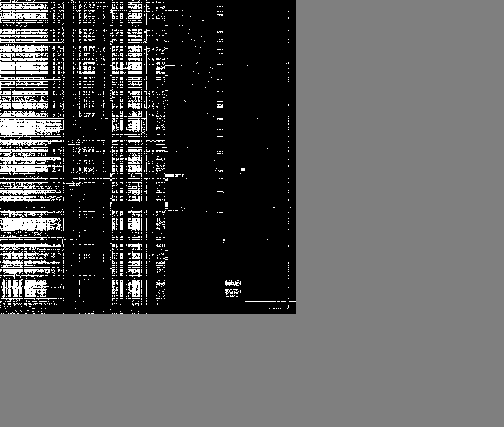

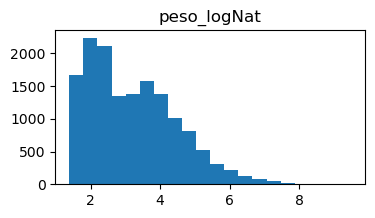



COMPAÑÍA: 3
Number of users: 384
Number of items: 65
Number of interactions: 847


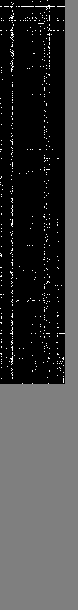

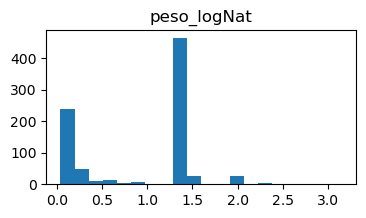



COMPAÑÍA: 4
Number of users: 2
Number of items: 3
Number of interactions: 5


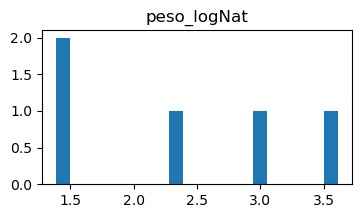



COMPAÑÍA: 5
Number of users: 21
Number of items: 111
Number of interactions: 419


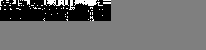

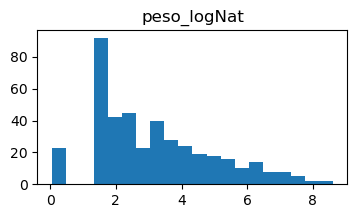



COMPAÑÍA: 6
Number of users: 244
Number of items: 749
Number of interactions: 4990


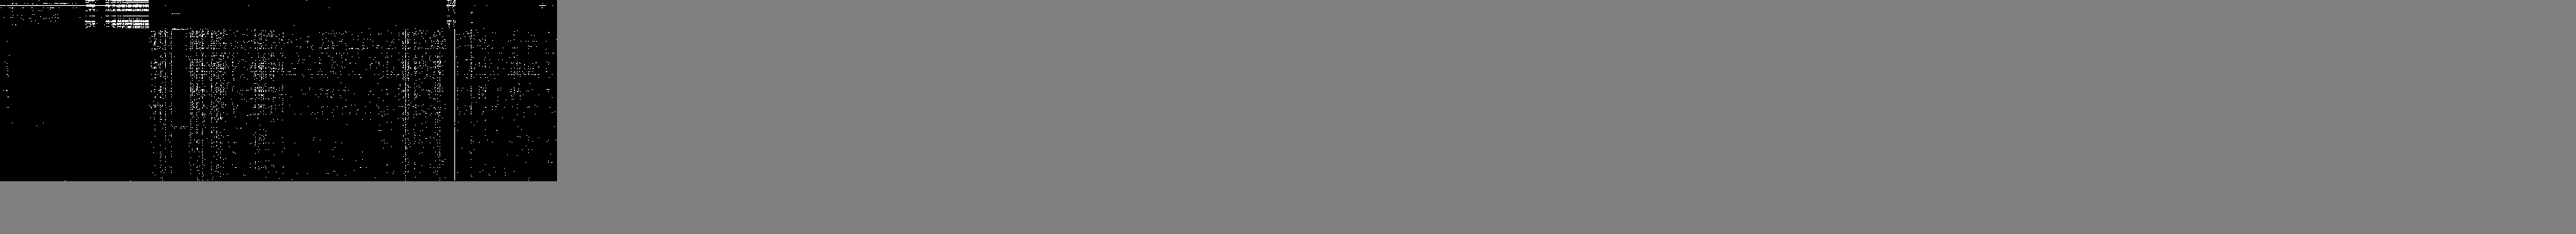

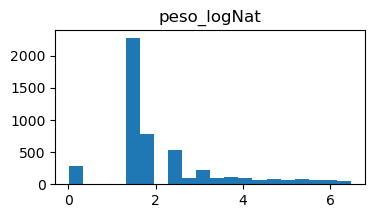



COMPAÑÍA: 7
Number of users: 6
Number of items: 34
Number of interactions: 41


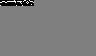

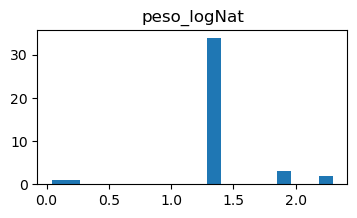



COMPAÑÍA: 8
Number of users: 5
Number of items: 21
Number of interactions: 25


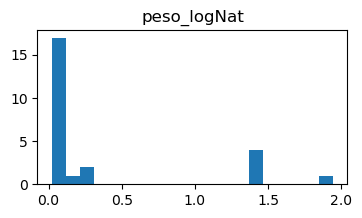



COMPAÑÍA: 9
Number of users: 8
Number of items: 93
Number of interactions: 111


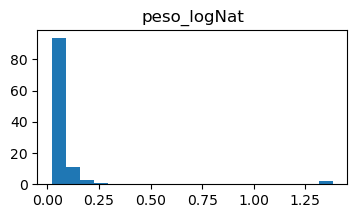



COMPAÑÍA: 10
Number of users: 102
Number of items: 111
Number of interactions: 541


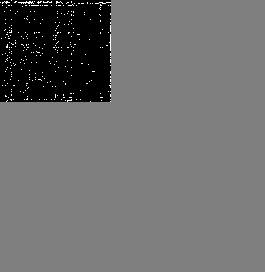

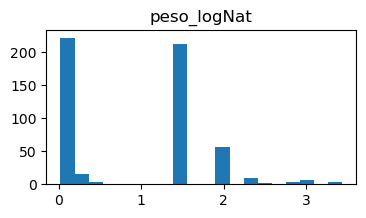



COMPAÑÍA: 12
Number of users: 166
Number of items: 1218
Number of interactions: 1784


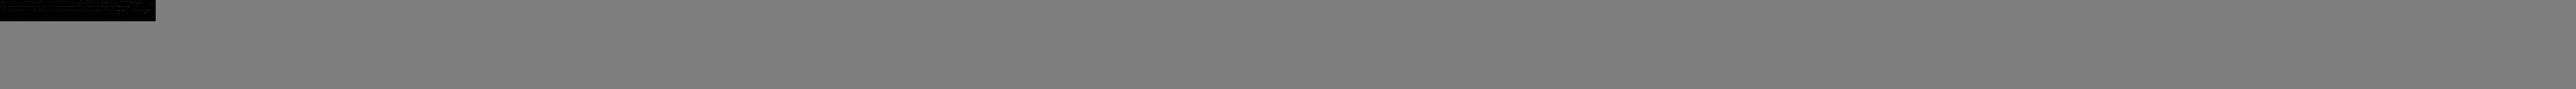

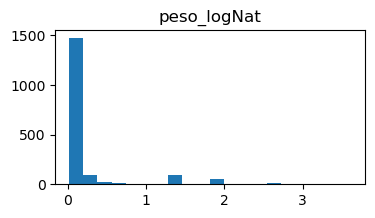



COMPAÑÍA: 18
Number of users: 2
Number of items: 2
Number of interactions: 2


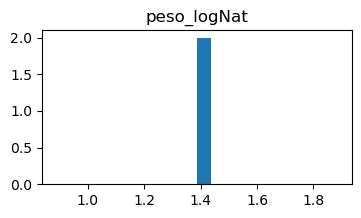



COMPAÑÍA: 19
Number of users: 5
Number of items: 32
Number of interactions: 42


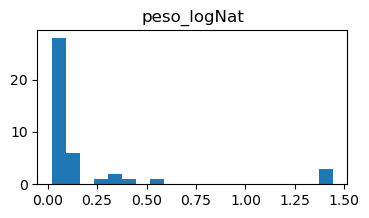



COMPAÑÍA: 29
Number of users: 467
Number of items: 39
Number of interactions: 663


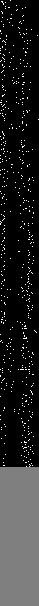

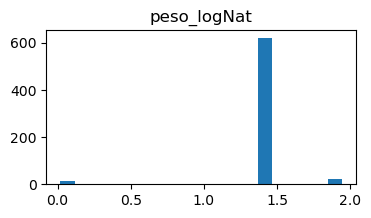



COMPAÑÍA: 30
Number of users: 1
Number of items: 30
Number of interactions: 30


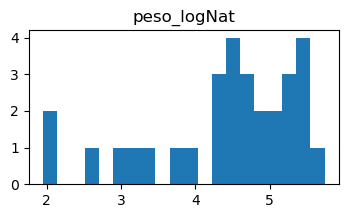



COMPAÑÍA: 31
Number of users: 86
Number of items: 23
Number of interactions: 201


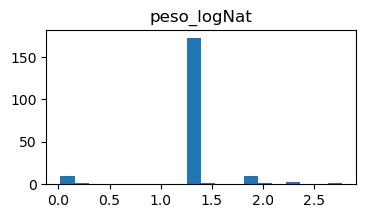



COMPAÑÍA: 32
Number of users: 29
Number of items: 18
Number of interactions: 103


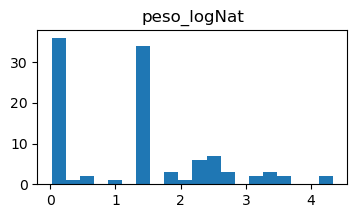



COMPAÑÍA: 34
Number of users: 8
Number of items: 13
Number of interactions: 14


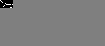

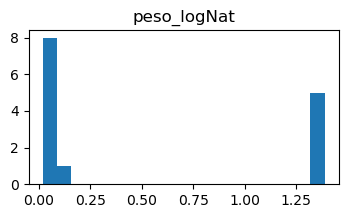



COMPAÑÍA: 35
Number of users: 44
Number of items: 50
Number of interactions: 260


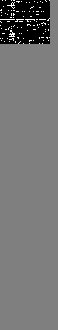

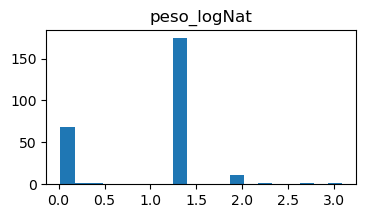



COMPAÑÍA: 44
Number of users: 1
Number of items: 4
Number of interactions: 4


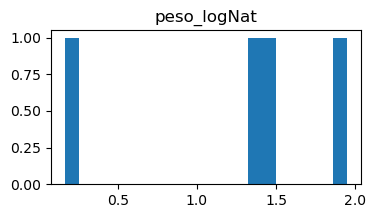

In [25]:
for comp_id in [1,3,4,5,6,7,8,9,10,12,18,19,29,30,31,32,34,35,44]:
    print("\n\nCOMPAÑÍA:", comp_id)
    rs = RecSys(*get_dfs_company(comp_id), userName="customer_id", itemName="product_id", scoreName="peso_logNat")
    rs.draw_matrix()

In [45]:
rs = RecSys(*get_dfs_company(4))
rs.draw_matrix()

Number of users: 2
Number of items: 3
Number of interactions: 5


In [21]:
#explore_company( 23 )

In [27]:
def seePeso(pd_series):
    print("Min:", pd_series.min(), "Max:", pd_series.max(), "Mean:", pd_series.mean(), "Mode:", pd_series.mode()[0])
    pd_series.plot.hist(bins=200, figsize=(12,3))

Min: 0.02 Max: 13248.0 Mean: 5.739287019276839 Mode: 3.0


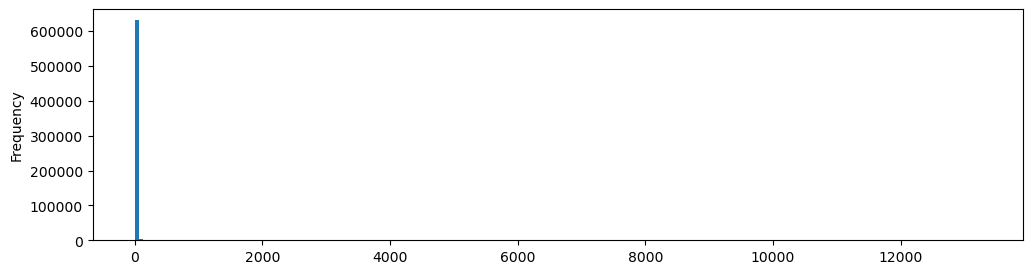

In [28]:
seePeso(df_relation.peso)

Min: 0.01980262729617973 Max: 9.491677356868124 Mean: 1.3854070950859176 Mode: 1.3862943611198906


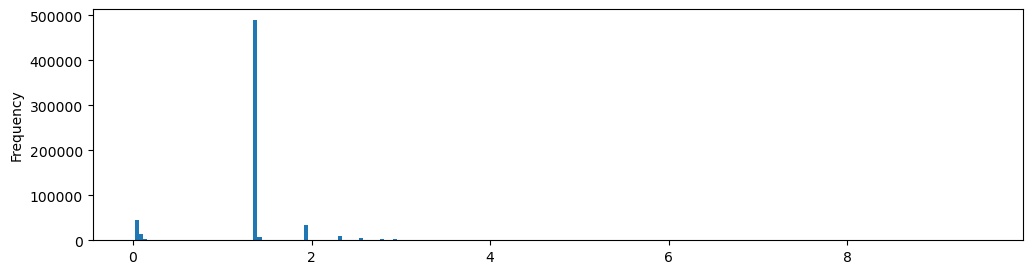

In [30]:
seePeso(df_relation.peso_logNat)

Min: 0.02856915219677092 Max: 13.693595852471706 Mean: 1.998719945692838 Mode: 2.0


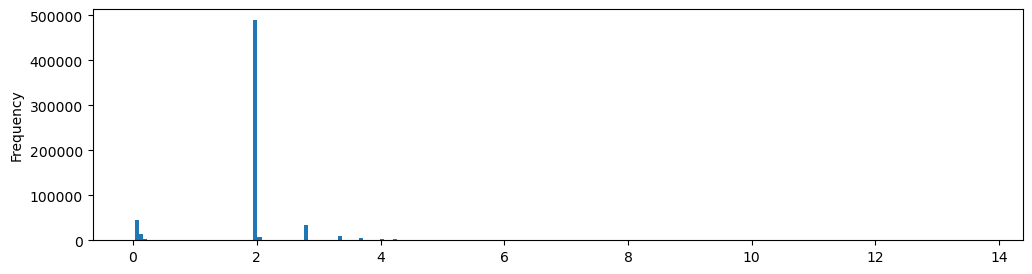

In [31]:
seePeso(df_relation.peso_logB2)

Min: 0.008600171761917567 Max: 4.122183100093868 Mean: 0.6016746565854277 Mode: 0.6020599913279624


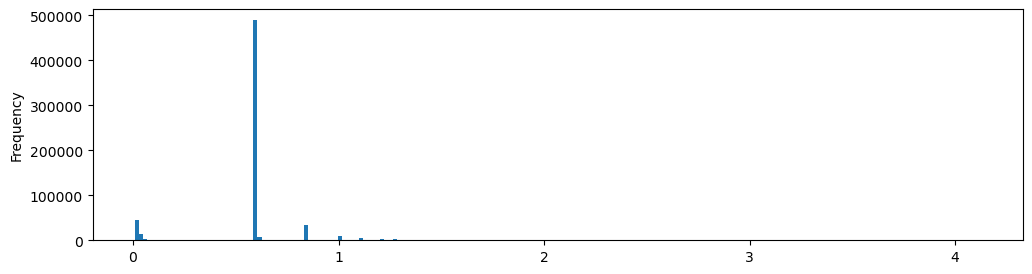

In [32]:
seePeso(df_relation.peso_logB10)

In [23]:
df_comp1_relation = df_relation[ df_relation.company_id==1 ]
df_comp23_relation = df_relation[ df_relation.company_id==23 ]
df_comp23_relation

,company_id,product_id,customer_id,peso,ultimo,peso_logNat,peso_logB2,peso_logB10
146424,23,28888,118364,0.08,2022-08-12 20:15:34,0.076961,0.111031,0.033424
146425,23,28890,532280,0.08,2022-08-12 20:08:26,0.076961,0.111031,0.033424
146426,23,28891,101041,0.08,2022-08-12 19:06:38,0.076961,0.111031,0.033424
146427,23,28892,116295,0.08,2022-08-12 11:14:09,0.076961,0.111031,0.033424
146428,23,28893,117588,0.08,2022-08-13 04:15:28,0.076961,0.111031,0.033424
...,...,...,...,...,...,...,...,...
636512,23,57621,537317,0.04,2022-01-14 10:09:18,0.039221,0.056584,0.017033
636513,23,57739,537317,0.04,2022-01-14 10:09:08,0.039221,0.056584,0.017033
636514,23,58193,111111,0.04,2022-10-02 23:16:52,0.039221,0.056584,0.017033
636515,23,58743,537565,0.04,2022-08-26 19:25:13,0.039221,0.056584,0.017033


In [20]:
dls = CollabDataLoaders.from_df(ratings=df_comp23_relation,
                                valid_pct=0.2,
                                user_name="customer_id",
                                item_name="product_id",
                                rating_name="peso_boxcox",
                                seed=None,
                                bs=64)

In [21]:
dls.show_batch()

,customer_id,product_id,peso_boxcox
0,103678,52095,1.217070
1,106182,52128,1.217070
2,102466,54429,-2.431309
3,119814,55365,1.217070
4,101704,51626,1.217070
5,104603,54587,3.163362
6,109085,51529,1.288723
7,104647,51473,1.217070
8,102744,50469,1.217070
9,112106,55206,1.217070


In [22]:
learn = collab_learner(dls, n_factors=50, y_range=(-3, 26), metrics=[mae])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,mae,time
0,32.867165,29.344473,4.384726,00:04
1,9.773914,11.014664,2.173610,00:04
2,5.756277,9.591437,1.962001,00:04
3,3.518925,9.243389,1.878011,00:04
4,2.503077,9.206673,1.863185,00:04


In [28]:
learn = collab_learner(dls, n_factors=50, y_range=(-3, 26), metrics=[mae])
learn.fit_one_cycle(5, lr_max=5e-3, wd=0.1)

epoch,train_loss,valid_loss,mae,time
0,31.172041,28.926107,4.342701,00:04
1,9.897020,10.968962,2.173523,00:04
2,5.556270,9.571959,1.960996,00:04
3,3.596327,9.269145,1.884384,00:04
4,2.608569,9.222979,1.863855,00:04


In [34]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(17393, 50)
  (i_weight): Embedding(5989, 50)
  (u_bias): Embedding(17393, 1)
  (i_bias): Embedding(5989, 1)
)

In [35]:
learn.model.u_weight

Embedding(17393, 50)

In [36]:
learn.model.u_weight.weight

Parameter containing:
tensor([[-0.0016,  0.0037,  0.0010,  ..., -0.0008,  0.0040, -0.0041],
        [-0.0716, -0.0509, -0.0683,  ..., -0.0347,  0.0673, -0.0733],
        [-0.0760, -0.0918, -0.0785,  ..., -0.0951,  0.0828, -0.0619],
        ...,
        [-0.0818, -0.0723, -0.0730,  ..., -0.0711,  0.0745,  0.0753],
        [-0.0226, -0.0100, -0.0013,  ..., -0.0036,  0.0172,  0.0155],
        [-0.0749, -0.0751, -0.0781,  ..., -0.0733,  0.0790,  0.0556]],
       device='cuda:0', requires_grad=True)

In [48]:
0.91**2

0.8281000000000001